# Stock Predictions using neural networks
## Ignacio Fernández Adrados
##### UOC (iadrados@uoc.edu)
---


This notebook creates multiple RNN and LSTM neural network models for predicting the movements of the stock exchange shares and evaluates the acuracy of the predictions for determining the recomendation of buying or selling shares depending on multiple parameters used for training the different models. Apart from the price of the shares used for the training, it analyzes the improvement of the predictions including sentiment analisys based on finantial news.

The sets of tests used for the training is built with the following parameters [and examples]: 

+ intervals         ['1min', '10min', '60min', '6h', '12h', '1D']
+ algorithms        ['RNN', 'LSTM']
+ steps             [2, 5, 10, 20]
+ units             [50, 100., 150]
+ batchs            [16,64,128]
+ profits           [0.1,1,10,100,1000]
+ epochs            [5, 10, 20]
+ sentiment         [True, False]
+ useFinBERT        [True, False]
+ relevance         0.0-1.0
+ useIndicators     [True, False]

It includes 2 different sentiment analysis approaches:

1. The first one under the parameter **sentiment** is based in the sentiment datasets provided by Alpha Vantage (https://www.alphavantage.co/) wich apart from the header and the subject of the news, offers the calculated sentiment and the relevance of the calculation for every stock.

2. The test performed under the parameter **useFinBERT** is based on the pre-trained model found in https://huggingface.co/yiyanghkust/2finbert-tone created by {yang2020finbert,
    title={FinBERT: A Pretrained Language Model for Financial Communications},
    author={Yi Yang and Mark Christopher Siy UY and Allen Huang},
    year={2020},
    eprint={2006.08097},
    archivePrefix={arXiv},
    }


In [ ]:
! pip install numpy 
! pip install pandas
! pip install scikit-learn
! pip install matplotlib
! pip install numpy
! pip install keras
! pip install tensorflow
! pip install torch
! pip install tranformers

#The path to the datasets used in this notebook.
FILE_PATH = 'Datasets/'  

### getStockDataFrame()

Reads the stock exchange datasets of different years and concatenates them in a single DataFrame

In [5]:
import pandas as pd # type: ignore

def getStockDataFrame (stock, years):
    
    df = None
    for year in years:
        FILE = FILE_PATH + 'Stock-'+stock+'-'+year+'.csv'
        ds=pd.read_csv(FILE, sep=',')
        #Concatenation of sequential read datasets
        df = pd.concat([df,ds])
        
    #Sort the returned dataframe by timestamp
    df = df.sort_values(by='timestamp', ascending=True)
    return df

### groupStocks(dataset, interval)

Groups every stock dataset fields into a single value by each interval chosen 

In [28]:
from datetime import datetime

def groupStocks(dataset, interval):

    dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
    
    #Groups the data by interval depending on each field value
    dfgroup = pd.DataFrame(dataset.groupby(pd.Grouper(key='timestamp', freq=interval)).first()['open'])
    dfgroup = dfgroup.join(dataset.groupby(pd.Grouper(key='timestamp', freq=interval)).last()['close'])
    dfgroup = dfgroup.join(dataset.groupby(pd.Grouper(key='timestamp', freq=interval)).min()['low'])
    dfgroup = dfgroup.join(dataset.groupby(pd.Grouper(key='timestamp', freq=interval)).max()['high'])
    dfgroup = dfgroup.join(dataset.groupby(pd.Grouper(key='timestamp', freq=interval)).sum()['volume'])
    
    #Formats the returned data
    dfgroup = pd.DataFrame(pd.to_datetime(dfgroup.index[:])).join(dfgroup.reset_index(drop=True))
    dfgroup = dfgroup.dropna().reset_index(drop=True)
    
    return dfgroup

### get_rsi(close, lookback)

Generates de RSI indicator by its technical definition

In [7]:
#Calculate the RSI technical indicator
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

### getIndicators(dataset)

Obtains the EMA7, MACD, SignalMACD and RSI indicators and joins them in the returned original dataset

In [8]:
def getIndicators(dataset):

    #Inserts into the main dataset all the calculated technical indicators
    #EMA7
    dataset['EMA7']= dataset['close'].ewm(span=7, adjust=False).mean()
    #MACD
    dataset['MACD']= dataset['close'].ewm(span=12, adjust=False).mean()- dataset['close'].ewm(span=26, adjust=False).mean()
    #SignalMACD
    dataset['SignalMACD'] = dataset['MACD'].ewm(span=9, adjust=False).mean()
    #RSI
    dataset['RSI'] = get_rsi(dataset['close'], 14)
    #Formats the dataset
    dataset = dataset.dropna()
    dataset = dataset.reset_index(drop=True)
    return dataset

### getNewsDataFrame(stock, dates, interval, stockDataFrame, relevance)

Gets the NEWS dataframe of the specific **stock** between the specific **dates**, groups the fields into the selected **interval** filetring the news with a **relevance** higher than the specified one and storing the result into the main stock dataset by joinin all the information together (stock data + sentiment data)

In [9]:
def getNewsDataFrame(stock, dates, interval, stockDataFrame, relevance):
   
    #Reads the stock datasets and concatenate them in a single dataframe
    file = None
    for year in dates:
        FILE = FILE_PATH + 'News-'+stock+'-'+year+'.csv'
        ds=pd.read_csv(FILE, sep=',')
        file = pd.concat([file,ds])
    file = file.sort_values(by='date', ascending=True)
    
    #Formats datetime filed, discard non needed fields and filters by relevance
    file['date'] = pd.to_datetime(file['date'], format='%Y%m%dT%H%M%S')
    file = file.drop(['title','summary','ticker'], axis=1)
    file = file[file['relevance']>=relevance]
    
    #Groups the news by the chosen interval by choosing the last news of every interval
    dfgroup = pd.DataFrame(file.groupby(pd.Grouper(key='date', freq=interval)).last()['relevance'])
    dfgroup = dfgroup.join(file.groupby(pd.Grouper(key='date', freq=interval)).last()['sentiment'])

    #Formats the generated dataframe
    dfgroup = pd.DataFrame(pd.to_datetime(dfgroup.index[:])).join(dfgroup.reset_index(drop=True))
    dfgroup = dfgroup.fillna(0)
    stockDataFrame['timestamp'] = pd.to_datetime(stockDataFrame['timestamp'])
    res = stockDataFrame.join(dfgroup.set_index("date"), on='timestamp', how='left')
    res = res.fillna(0)
    res = res.reset_index(drop=True)

    return res

### normalize(dataset)

Normalize data between 0 and 1

In [10]:
from sklearn.preprocessing import MinMaxScaler  # type: ignore

def normalize(dataset):
    normData=dataset

    #Normalize data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    c=normData.columns.values
    normData[c] = scaler.fit_transform(normData[c])

    return normData

### plotDataset(dataset)

Plots the stock 'close' value for each interval

In [11]:
import matplotlib.pyplot as plt  # type: ignore

def plotDataset(dataset):
    
    plt.figure(figsize=(14,4))
    plt.title("Stock Data")
    plt.plot(dataset['close'],color='black')
    plt.show()

### splitData(dataset, split, step) 

Split the values in train and test by the percentaje of data specified in **split**

In [12]:
def splitData(dataset, split, step):

    split = int(len(dataset) * split)
    train = dataset[:split]
    test = pd.concat([train.tail(step),dataset[split:]]).reset_index(drop=True)

    return train, test

### plotSplitDataset(dataset, split)

Plots the dataset by differenciating train set from test set

In [13]:
def plotSplitDataset(dataset, split):
    
    normData = dataset
    split = int(len(normData) * split)

    plt.figure(figsize=(14,4))
    plt.title("Split stock data")
    plt.plot(normData.index.values,normData['close'],c='black')
    plt.axvline(normData.index[split], c="r")
    plt.show()


### convertToMatrix(data, step)
### dataset2Matrix (train, test, step)
Convers to a multi-dimensional array

In [14]:
import numpy as np  # type: ignore

def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        X.append(data[i:d])
        Y.append(data[d,1])
    return np.array(X), np.array(Y)

def dataset2Matrix(train, test, step):
    trainX,trainY =convertToMatrix(train.to_numpy(),step)
    testX,testY =convertToMatrix(test.to_numpy(),step)
    return trainX, trainY, testX, testY


### createModel (type, units, trainX, step)

Uses Keras for creating the models (RNN or LSTM) depending on parameters units and step

In [15]:
from keras import Sequential # type: ignore
from keras.layers import Dense, SimpleRNN, Input, LSTM, Dropout # type: ignore

def createModel(type, units, trainX, step):
    
    model = Sequential()
    model.add(Input((step, trainX.shape[2])))

    #Creation of LSTM model
    if type=="LSTM":
        model.add(LSTM(units=units, activation="tanh",return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=units//2, activation="tanh"))
        model.add(Dropout(0.2))      
    
    #Creation of RNN model
    elif type == "RNN":
        model.add(SimpleRNN(units=units, activation="relu",return_sequences=True))
        model.add(Dropout(0.2))
        model.add(SimpleRNN(units=units//2, activation="relu"))
        model.add(Dropout(0.2))     
    model.add(Dense(32, activation="tanh"))
    model.add(Dense(1))

    #Model compile
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])    
    
    return model

### trainModel(model, batch, epoch, trainX, trainY)

Training of the model

In [16]:
def trainModel(model, batch, epochs, trainX, trainY):
    batch_size=batch
    num_epochs = epochs

    model.fit(trainX,trainY,
            epochs=num_epochs,
            batch_size=batch_size,
            callbacks=None,verbose=0
            )
    return model

### plotLoss(model) 

Plots the loss of the model

In [17]:
def plotLosss(model):
    plt.figure(figsize=(14,4))
    plt.title("RMSE loss over epochs",fontsize=18)
    plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Root-mean-squared error")
    plt.xticks()
    plt.yticks()
    plt.show()

### predict(model, trainX, testX)

Prediction of the model

In [18]:
def predict(model, trainX, testX):
    trainPredict = model.predict(trainX, verbose=0)
    testPredict= model.predict(testX, verbose=0)
 
    return trainPredict, testPredict


### plotcompare(normData, testPredict, split)

Plots the comparison bewtween the ground truth and the predicted model

In [19]:
def plotCompare(normData, testPredict, split):

    OFFSET = 0 #Increment in case only a part of the data must be represented  

    split = int(len(normData) * split)
    plt.figure(figsize=(14,4))
    plt.title("Ground truth and prediction together",fontsize=18)
    plt.plot(normData['close'].iloc[split+OFFSET:].reset_index(drop=True),color='black', label='Ground Truth')
    plt.plot(testPredict[OFFSET:],color='blue', label='Prediction')
    plt.legend()
    plt.show()

### calculateDecision(test, testPredict, step, profit)

Calculates the moment on wich the expected profit in the ground truth should recomend buying or selling and compares it with the points of the predicted data on wich the recomendation shoul have been triggerd based on the profit.

In [20]:
def calculateDecision(test, testPredict, step, profit):

    #Calculates the poins in the original dataset values on wich the difference with the previous value 
    # is higher than the expected profit. 
    decision = test['close'].iloc[step:]
    decision = decision.diff()
    decision = decision.dropna()
    decision = np.where(abs(decision)<profit,0,np.sign(decision).astype('int'))
    decision = pd.DataFrame(data={'buysell':decision})

    #Makes the same calculation over the predicted dataframe
    predictedDecision = pd.DataFrame(data={'buysellPredicted':testPredict[:,0]})
    predictedDecision = predictedDecision.diff()
    predictedDecision = predictedDecision.dropna()
    predictedDecision = np.where(abs(predictedDecision)<profit,0,np.sign(predictedDecision).astype('int'))
    predictedDecision = pd.DataFrame(data={'buysellPredicted':predictedDecision[:,0]})
    
    #Joins both dataframes in a single dataframe and returns it
    decision = decision.join(predictedDecision)

    return decision

### plotBuySell(normData, testPredict, split, profit, decision)

Plots the ground truth chart pointing the recommended transactions compared with the recommended transactions by the prediction

In [21]:
def plotBuySell(normData, testPredict, split, profit, decision):

    PROFIT=profit
    OFFSET=0
    split = int(len(normData) * split)    

    index = normData.index.values
    plt.figure(figsize=(14,4))
    plt.title("Ground truth recommendation vs prediction recommendation",fontsize=18)
    plt.plot(normData['close'].iloc[split+OFFSET:].reset_index(drop=True),color='black')
    plt.plot(testPredict[OFFSET:],color='blue')

    x = decision.iloc[OFFSET:].reset_index(drop=True).index
    y = normData['close'].iloc[len(normData)-len(decision.index)-1+OFFSET:-1].reset_index(drop=True)

    plt.scatter(x, np.where(decision['buysell'].iloc[OFFSET:] == -1,y, None), color="red",  marker="v", label='Ground Truth Sell')
    plt.scatter(x, np.where(decision['buysell'].iloc[OFFSET:] ==  1,y, None), color="blue", marker="^", label='Ground Truth Buy')

    plt.scatter(x, np.where(decision['buysellPredicted'].iloc[OFFSET:] == -1,y-0.015, None), color="orange",  marker="v", label='Prediction Sell')
    plt.scatter(x, np.where(decision['buysellPredicted'].iloc[OFFSET:] ==  1,y+0.015, None), color="green",  marker="^", label='Prediction Buy')
    plt.legend()
    plt.show()


### plotProfit(normData, split, decision)

Plots the coincidence of recomendation vs the discrepancy

In [22]:
def plotProfit(normData, split, decision):

    OFFSET = 0 #Increment in case only a part of the data must be represented  

    split = int(len(normData) * split)
    plt.figure(figsize=(14,4))
    plt.title("Recommended buy/sell vs not recommended",fontsize=18)
    plt.plot(normData['close'].iloc[split+OFFSET:].reset_index(drop=True),color='black')

    x = decision.iloc[OFFSET:].reset_index(drop=True).index
    y = normData['close'].iloc[len(normData)-len(decision.index)-1+OFFSET:-1].reset_index(drop=True)

    plt.scatter(x, np.where((decision['buysell'].iloc[OFFSET:] !=  decision['buysellPredicted'].iloc[OFFSET:]) & (decision['buysellPredicted'].iloc[OFFSET:] != 0),y, None), color="red", label='Ground Truth Buy')
    plt.scatter(x, np.where((decision['buysell'].iloc[OFFSET:] == decision['buysellPredicted'].iloc[OFFSET:]) & (decision['buysell'].iloc[OFFSET:] != 0),y, None), color="green",  label='Ground Truth Sell')

    plt.legend()
    plt.show()

### calculateProfit(normData, decision)

Returns the values related to the number of coincidences and no coincidences in the recommendations

In [23]:
def calculateProfit(normData, decision):

    OFFSET=0

    y = normData['close'].iloc[len(normData)-len(decision.index)-1+OFFSET:-1].reset_index(drop=True)
    
    # Calculate the poins on which the buy-sell recommendation has no coincide between ground truth and prediction
    nocoincide =np.count_nonzero(np.where((decision['buysell'].iloc[OFFSET:] !=  decision['buysellPredicted'].iloc[OFFSET:]) \
          & (decision['buysellPredicted'].iloc[OFFSET:] != 0),y, None))
    
    # Calculate the poins on which the buy-sell recommendation has coincide between ground truth and prediction
    coincide=np.count_nonzero(np.where((decision['buysell'].iloc[OFFSET:] == decision['buysellPredicted'].iloc[OFFSET:]) \
          & (decision['buysell'].iloc[OFFSET:] != 0),y, None))
    
    return coincide, nocoincide

## FinBERT-tone
### getFinBERTdata(stock, dates)

Loads the datasets containing finantial news and calculates the sentiment based on the model https://huggingface.co/yiyanghkust/2finbert-tone created byHuang, Allen H., Hui Wang, and Yi Yang. "FinBERT: A Large Language Model for Extracting Information from Financial Text." Contemporary Accounting Research (2022)

In [24]:
def  getFinBERTdata(stock, dates):
    
    from transformers import BertTokenizer, BertForSequenceClassification, pipeline  # type: ignore

    #Get FinBERT model from Huffing Face
    finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
    tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

    #Configure the prediction model
    nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)
    
    #Reads the files with the news
    file = None
    for year in dates:
        FILE = FILE_PATH + 'News-'+stock+'-'+year+'.csv'
        ds=pd.read_csv(FILE, sep=',')
        file = pd.concat([file,ds])
    file = file.sort_values(by='date', ascending=True)
    file = file[file.relevance >0.7].reset_index(drop=True)

    #Selecs the fields with the news headers
    headlines_array = np.array(file)
    headlines_list = list(headlines_array[:,1])
    
    #Executes the model
    results =nlp(headlines_list)

    #Store the result in a dataframe
    pdr = pd.DataFrame(results)
    file["FinBertScore"]= pdr["score"]
    file["FinBertLabel"]= pdr["label"]
    
    return file

### getFinbertNewsDataFrame(data, newsdata, interval)

Extracts the score obtained in the result obtained in FinBERT and groups the information in the selected interval for returning a dataframe with all the required information

In [25]:
def getFinbertNewsDataFrame(data, newsdata, interval):
    
    # Reads and format the received dataframe
    file = newsdata.sort_values(by='date', ascending=True)
    file['date'] = pd.to_datetime(file['date'], format='%Y%m%dT%H%M%S')
    file = file.drop(['title','summary','ticker', 'relevance','sentiment', 'FinBertLabel'], axis=1)

    #Groups the score by interval  
    dfgroup = pd.DataFrame(file.groupby(pd.Grouper(key='date', freq=interval)).last()['FinBertScore'])
    
    #Formats the result
    dfgroup = pd.DataFrame(pd.to_datetime(dfgroup.index[:])).join(dfgroup.reset_index(drop=True))
    dfgroup = dfgroup.fillna(0)
    
    #Joins the result with the main dataframe
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    res = data.join(dfgroup.set_index("date"), on='timestamp', how='left')
    res = res.fillna(0)
    res = res.reset_index(drop=True)

    return res    

runTest(...)

Executes a battery of tests based on the received parameters.

In [52]:
def runTest(split, stock, dates, profitFactor, intervals, algorithms,  steps, \
            units, batchs, profits, epochs, sentiment, relevance, useIndicators, \
            useFinBERT, printFinalData=False, printSplitDataset=False, \
            printModelSummary=False, printLoss=False, printCompare=False, \
            printBuySell=False, printProfit=False, exportDataset=True):
    
    df = None
    numberoftests = len(intervals) * len(algorithms) * len(steps) * len(units) *  \
    len(batchs) * len(profits) * len(epochs) * len(sentiment) * len(useIndicators) * len(useFinBERT)
    
    if True in useFinBERT:
        print("Calculating FinBERT finantial sentiment predictions...")
        newsdata = getFinBERTdata(stock, dates)
        print("Finantial sentiment stored in dataset")
    
    originalData = getStockDataFrame(stock, dates )

    print ('Running', numberoftests, 'tests:')
    
    for interval in intervals:
        for algorithm in algorithms:
            for step in steps:
                for unit in units:
                    for batch in batchs:
                        for epoch in epochs:
                            for indicator in useIndicators:
                                for sent in sentiment:
                                    for finbert in useFinBERT:                                        
                                        data = originalData
                                        data = groupStocks(data,interval)
                                      
                                        if useIndicators:
                                            data = getIndicators(data)
                                                                            
                                        if sent:
                                            data = getNewsDataFrame(stock, dates, \
                                                    interval, data, relevance)
                                          
                                        if finbert:
                                            data = getFinbertNewsDataFrame(data, newsdata, interval)
                                                                                  
                                        data = data.drop(["timestamp"], axis=1)
                                        finalData = normalize(data)                            
                                           
                                        if printFinalData:
                                            plotDataset(finalData)
                                        
                                        train, test = splitData(finalData, split, step)
                                        
                                        if printSplitDataset:
                                            plotSplitDataset(finalData, split)

                                        trainX, trainY, testX, testY = dataset2Matrix(train, test, step)
                                       
                                        model = createModel(algorithm, unit,trainX, step)
                                        
                                        if printModelSummary:
                                            model.summary()
                                        
                                        trainedModel = trainModel(model,batch,epoch,trainX,trainY)
                                        if printLoss:
                                            plotLosss(trainedModel)
                                        loss = np.sqrt(trainedModel.history.history['loss'][-1])
                                                              
                                        trainPredict, testPredict = predict(trainedModel,trainX, testX)
                                        if printCompare:
                                            plotCompare(finalData, testPredict, split)

                                        for profit in profits:
                                            decision = calculateDecision(test, testPredict, step, profit*profitFactor)
                                            
                                            if printBuySell:
                                                plotBuySell(finalData, testPredict,split, profit, decision)
                                            if printProfit:
                                                plotProfit(finalData, split, decision)
                                            coincide, nocoincide = calculateProfit(finalData, decision)
                                            if coincide+nocoincide == 0:
                                                ben = '-'
                                            else:
                                                ben = str(round(coincide/(coincide+nocoincide)*100,2))+'%'
                                            df = pd.concat([df, pd.DataFrame({
                                                'Interval': ["{:>3}".format(interval)],
                                                'Algorithm': ["{:>5}".format(algorithm)],
                                                'Steps':["{:3}".format(step)],
                                                'Units':["{:4}".format(unit)],
                                                'Batchs':["{:5}".format(batch)],
                                                'Epochs':["{:3}".format(epoch)],
                                                'ExpectedProfit':["{:11.8f}".format(profit*profitFactor)],
                                                'RMSELoss': ["{:9.6f}".format(loss)],
                                                'Indicators' : ["{:>6}".format(str(indicator))],
                                                'CalculatedSentiment' : ["{:>6}".format(str(sent))],
                                                'FinBERTSentiment' : ["{:>6}".format(str(finbert))],
                                                'Relevance' : ["{:>4}".format(relevance)],
                                                'GoodPrediction': ["{:4}".format(coincide)],
                                                'BadPrediction': ["{:4}".format(nocoincide)],
                                                'Accuracy': ["{:>7}".format(ben)]                                    
                                            })])

                                            print(df.iloc[-1:].to_string(header=False, index=False))
                                            
                                            #Export dataset to CSV
                                            if exportDataset:
                                                df.to_csv(FILE_PATH + 'Tests_Results-' + stock + str(dates)+ \
                                                    'Interval-' + str(intervals) + str(algorithms) + 'Steps-' + \
                                                    str(steps) + 'Units-' + str(units) + 'Batchs-' + str(batchs)+ \
                                                    'Epochs-' + str(epochs) + 'profitFactor-' + str(profitFactor) + \
                                                    '.csv', index=False)                                
    df.reset_index(drop=True)
    print("Tests finished")


### Battery of tests for creating and evaluating the neural networks models

Example of parameters used for testing:

+ split = 0.7,                    #Percentage of split between train data and test data
+ stock ='AMZN',                  #Stock company chosen for the analysis
+ dates = ['2022','2023'],        #Dates of the present datasets for loading data
+ profitFactor = 0.000001,        #Mulitiplicative factor for the expected profts
+ intervals = ['12h'],            #Analyzed intervals, i.e.:['1min', '10min', '60min', '6h', '12h', '1D']
+ algorithms = ['LSTM'],          #Algorithm, i.e.: ['RNN', 'LSTM']
+ steps = [10, 20],               #Steps of data selected for generating the model
+ units = [100,150,200],          #Units chosen for the creation of RNN and LSTM models
+ batchs = [16,64,128],           #Batch parameter for the creation of the model
+ profits = [0.1,1,10,100,1000] , #Expected profits (in combination with profitFactor)
+ epochs = [5, 10],               #Number of epoch used for the training
+ sentiment = [True, False],      #Use of the sentiment provided by the Alpha Vantage datasets
+ relevance = 7.0,                #Value of the minimum relevance (0.0-1.0) of the news that will be used in the model
+ useFinBERT =[True, False],      #Use of the model FinBERT for providing sentiment analysis
+ useIndicators = [True, False],  #Include the technical indicators in the training of the model
+ printFinalData=False,           #Plots the original dataset
+ printSplitDataset=False,        #Plots the split dataset
+ printModelSummary=False,        #Print the summary of the created model
+ printLoss=False,                #Plots the RMSE loss of each model
+ printCompare=False,             #Plots the comparison ground truth vs prediction
+ printBuySell=False,             #Plots the comparison of recommended - non-recommended coincidences
+ printProfit=False               #Plots the correct recommendation vs the failed recommendation

---

Running 5 tests:


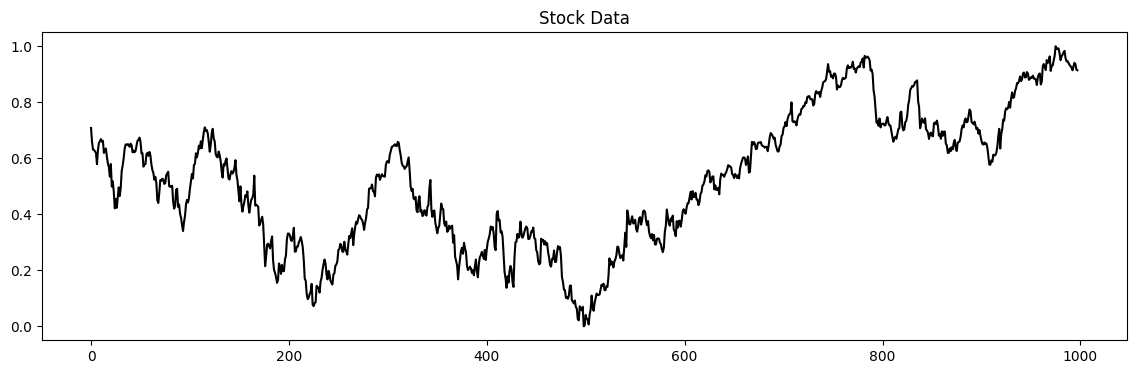

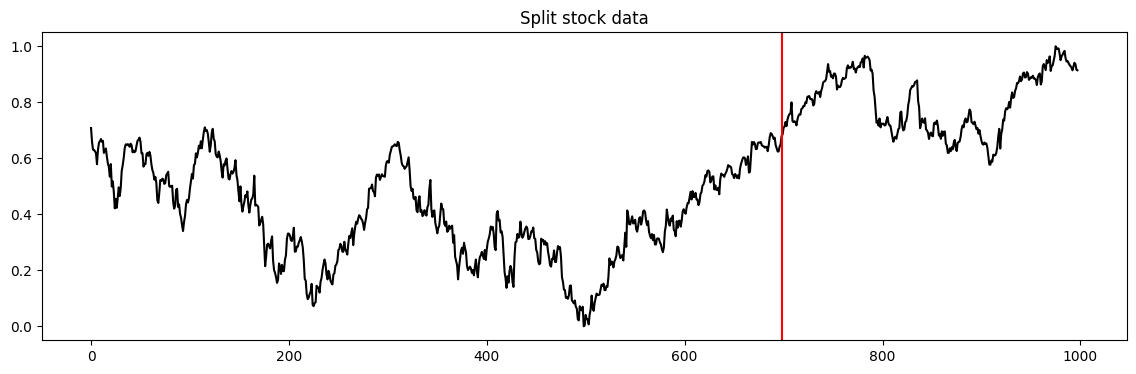

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 20, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 20, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 75)             │        67,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,265 (649.47 KB)

 Trainable params: 166,265 (649.47 KB)

 Non-trainable params: 0 (0.00 B)

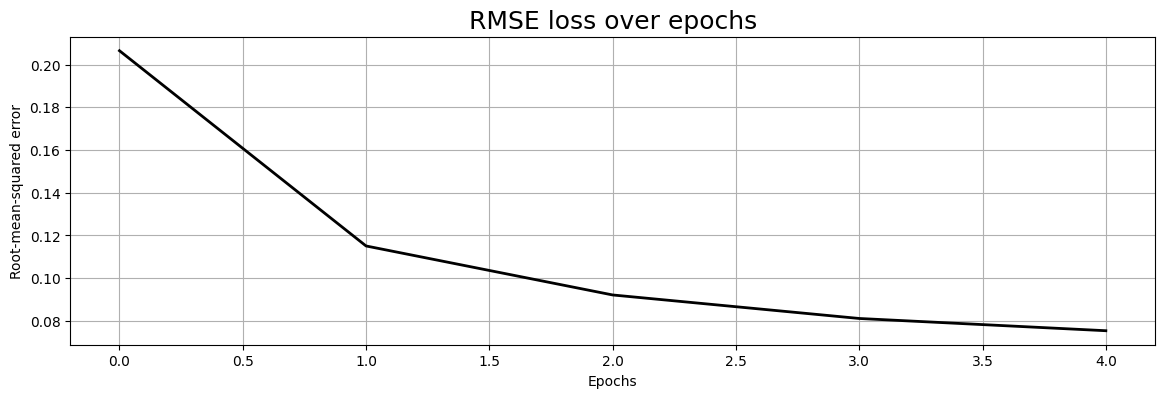

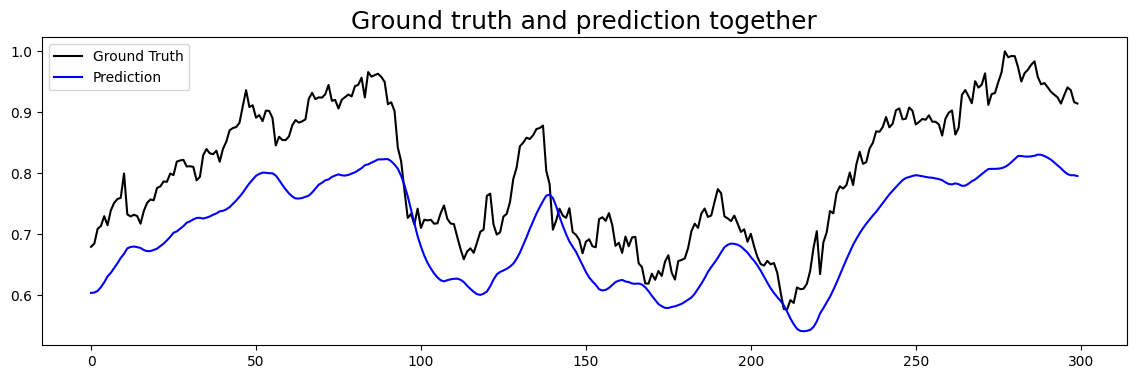

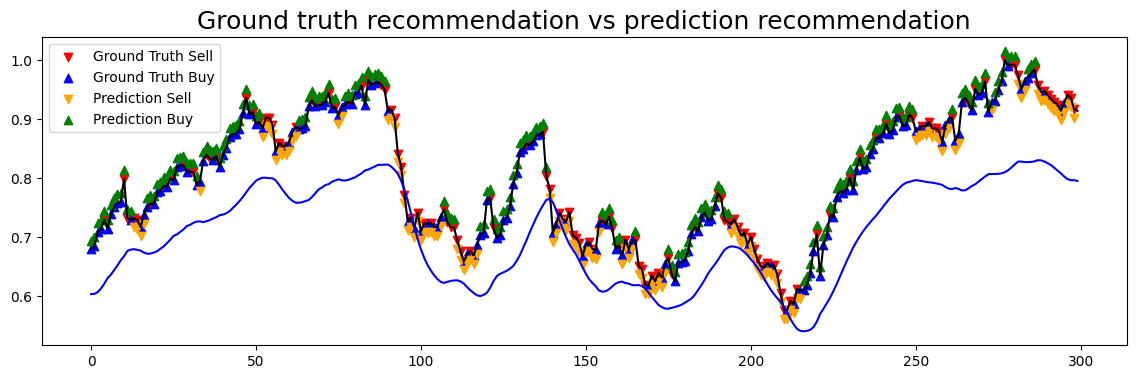

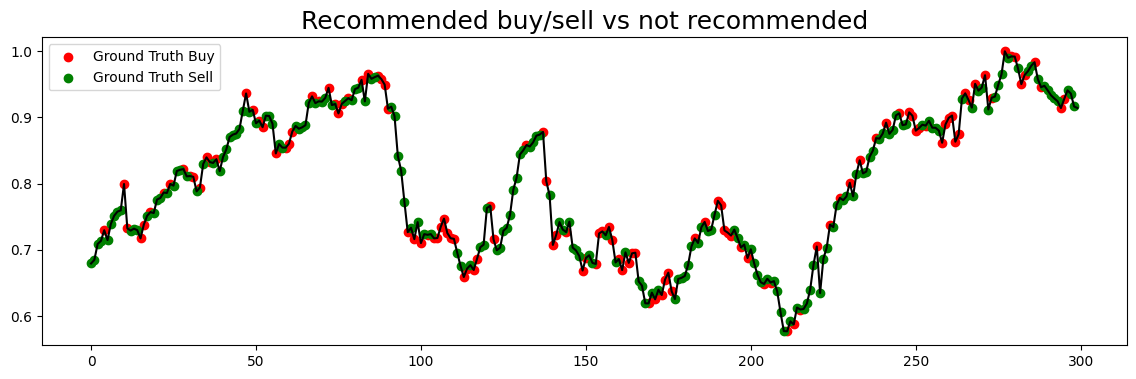

12h  LSTM  20  150   128   5  0.00000010  0.075382   True  False  False  7.0  175  124  58.53%


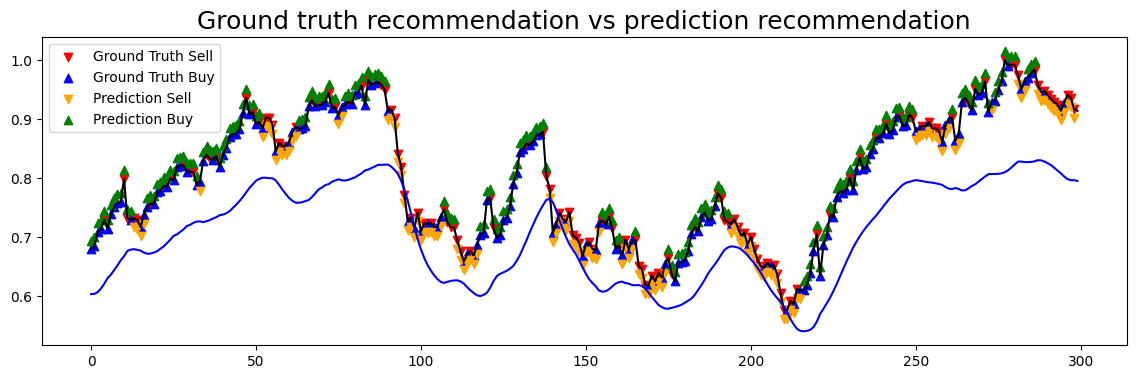

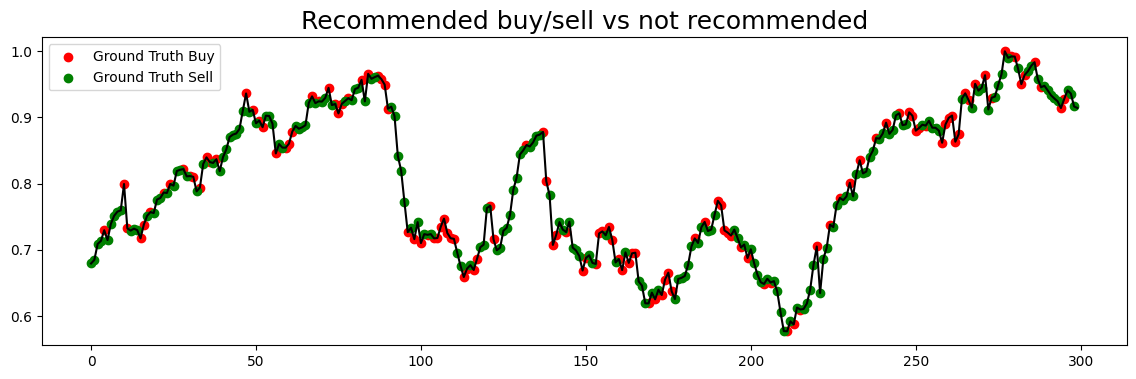

12h  LSTM  20  150   128   5  0.00000100  0.075382   True  False  False  7.0  175  124  58.53%


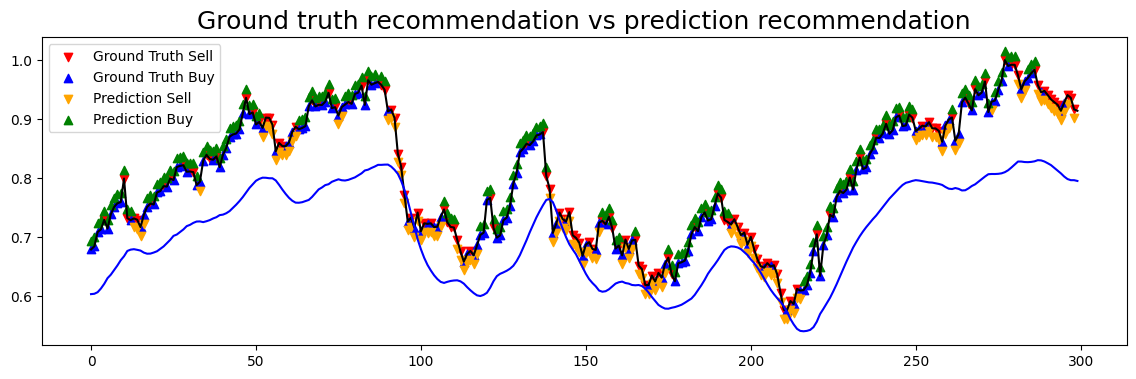

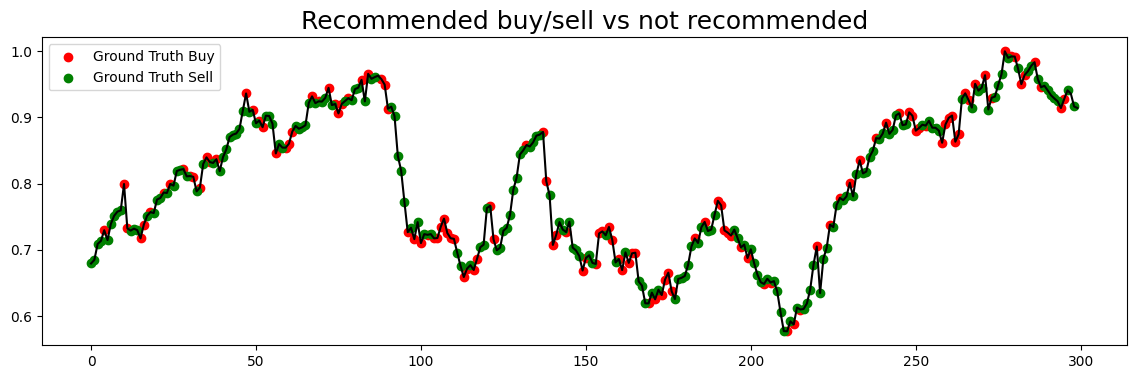

12h  LSTM  20  150   128   5  0.00001000  0.075382   True  False  False  7.0  174  123  58.59%


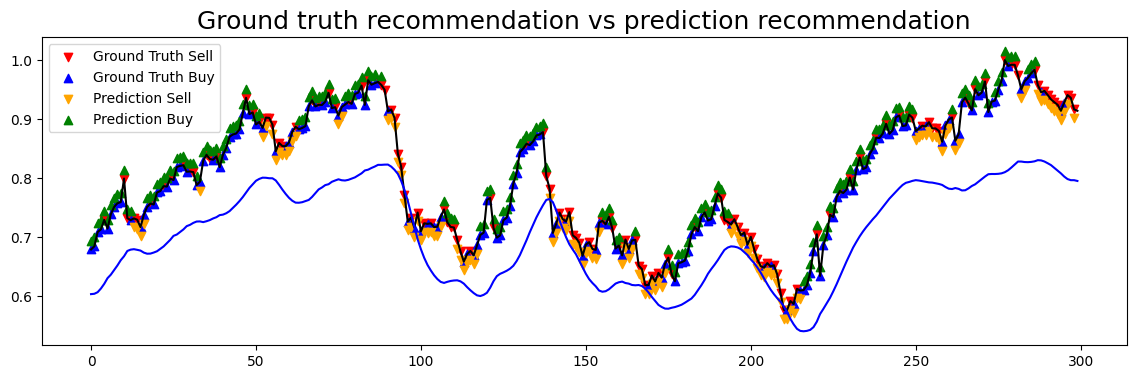

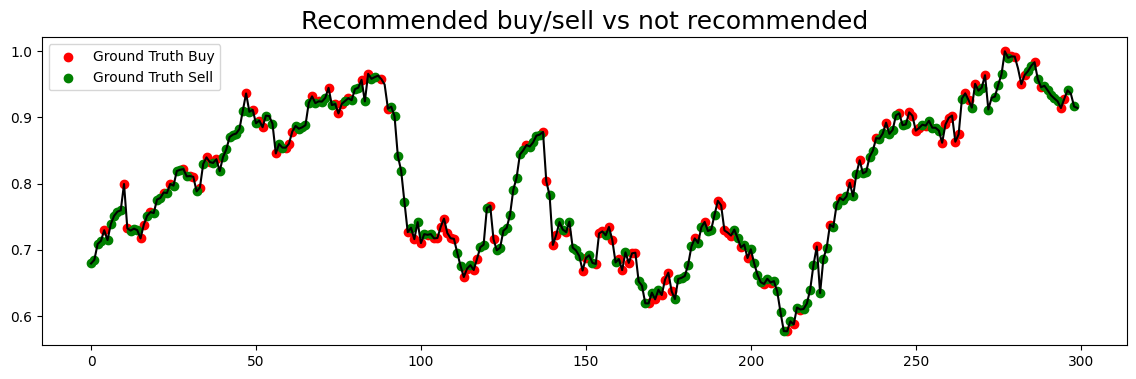

12h  LSTM  20  150   128   5  0.00010000  0.075382   True  False  False  7.0  172  121   58.7%


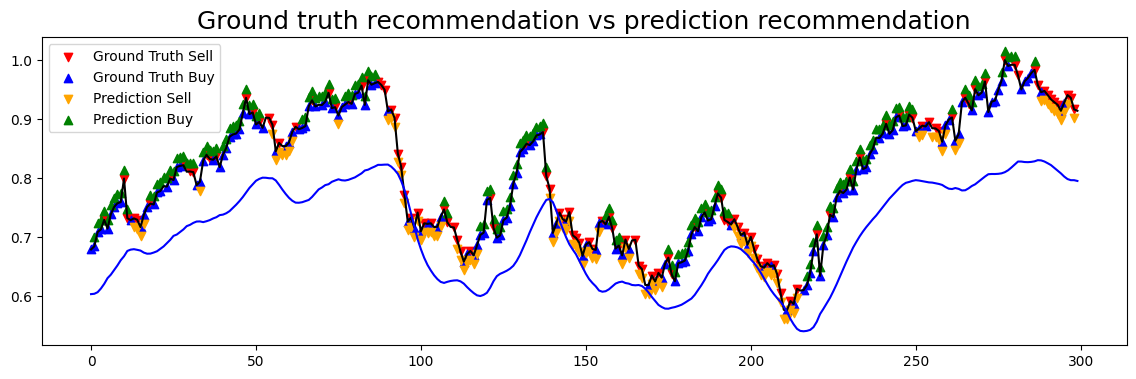

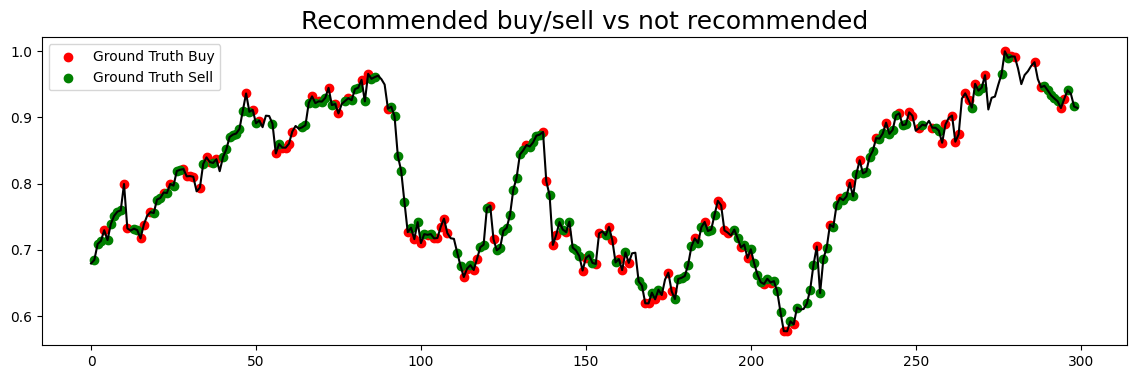

12h  LSTM  20  150   128   5  0.00100000  0.075382   True  False  False  7.0  150  110  57.69%
Tests finished


In [ ]:
runTest(
    split = 0.7,                    #Percentage of split between train data and test data
    stock ='AAPL',                  #Stock company chosen for the analysis
    dates = ['2022','2023'],        #Dates of the present datasets for loading data
    profitFactor = 0.000001,        #Mulitiplicative factor for the expected profts
    intervals = ['12h'],            #Analyzed intervals, i.e.:['1min', '10min', '60min', '6h', '12h', '1D']
    algorithms = ['LSTM'],          #Algorithm, i.e.: ['RNN', 'LSTM']
    steps = [20],                   #Steps of data selected for generating the model
    units = [150],                  #Units chosen for the creation of RNN and LSTM models
    batchs = [128],                 #Batch parameter for the creation of the model
    profits = [0.1,1,10,100,1000],  #Expected profits (in combination with profitFactor)
    epochs = [5],                   #Number of epoch used for the training
    useIndicators = [True],         #Include the technical indicators in the training of the model
    sentiment = [False],            #Use of the sentiment provided by the Alpha Vantage datasets
    relevance = 7.0,                #Value of the minimum relevance (0.0-1.0) of the news that will be used in the model
    useFinBERT =[False],            #Use of the model FinBERT for providing sentiment analysis
    printFinalData=True,            #Plots the original dataset
    printSplitDataset=True,         #Plots the split dataset
    printModelSummary=True,         #Print the summary of the created model
    printLoss=True,                 #Plots the RMSE loss of each model
    printCompare=True,              #Plots the comparison ground truth vs prediction
    printBuySell=True,              #Plots the comparison of recommended - non-recommended coincidences
    printProfit=True,               #Plots the correct recommendation vs the failed recommendation
    exportDataset = True            #Export the calculated results to a .csv file into the FILE_PATH directory
    ) 
